The following regressions are performed with those variables representing the racial and gender make up of schools, total number of students, and number of students that receive free or reduced lunch. The first set of regressions are performed without the charter school dummy, but the following set is. In both sets, OLS regressions are used initially, followed by Lasso and Ridge to determine the best predictors of test scores. 

Importing the necessary packages for the regressions.

In [187]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

df_combined = pd.read_csv('combined_data/combined.csv')
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10337 entries, 0 to 10336
Data columns (total 82 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   School Name                                                 10337 non-null  object 
 1   Agency Name                                                 10337 non-null  object 
 2   Agency ID - NCES Assigned                                   10337 non-null  float64
 3   County Name                                                 10337 non-null  object 
 4   County Number                                               10337 non-null  float64
 5   Charter School                                              10337 non-null  object 
 6   Title I School Status                                       10337 non-null  object 
 7   Congressional Code                                          10337 non-null  float64
 

In this cell, I drop rows with missing values in order to ensure the regressions work.

In [188]:
df_combined = df_combined.dropna()
print('Number of rows without missing data: ', df_combined.shape[0])
print('Number of charter and traditional schools:\n', df_combined['Charter School Dummy'].value_counts())
df_combined.head()

Number of rows without missing data:  10337
Number of charter and traditional schools:
 0    7705
1    2632
Name: Charter School Dummy, dtype: int64


,School Name,Agency Name,Agency ID - NCES Assigned,County Name,County Number,Charter School,Title I School Status,Congressional Code,National School Lunch Program,School Level,...,Title I: Schoolwide Eligible - Targeted Assistance Program,Title I Schoolwide Eligible School - No Program,Title I: Schoolwide School,Title I: Not a Title I School,2015,2016,2017,2018,2019,2022
0,Pine Forest School,Pine Forest Education Association Inc.,400018.0,COCONINO COUNTY,4005.0,1-Yes,2-Title I targeted assistance school,401.0,No,1-Primary,...,0,0,0,0,1,0,0,0,0,0
1,Pine Forest School,Pine Forest Education Association Inc.,400018.0,Coconino County,4005.0,1-Yes,2-Title I targeted assistance school,401.0,No,1-Primary,...,0,0,0,0,0,1,0,0,0,0
2,Pine Forest School,Pine Forest Education Association Inc.,400018.0,Coconino County,4005.0,1-Yes,2-Title I targeted assistance school,401.0,No,1-Primary,...,0,0,0,0,0,0,1,0,0,0
3,Pine Forest School,Pine Forest Education Association Inc.,400018.0,Coconino County,4005.0,1-Yes,2-Title I targeted assistance school,401.0,No,Elementary,...,0,0,0,0,0,0,0,1,0,0
4,Pine Forest School,Pine Forest Education Association Inc. (4201),400018.0,Coconino County,4005.0,1-Yes,2-Title I targeted assistance school,401.0,No,Elementary,...,0,0,0,0,0,0,0,0,1,0


Running an OLS regression on the input variables ('X') and output variable ('y').

In [189]:
# columns to be used for analysis
X = df_combined[['Total Students All Grades (Excludes AE)', 'Free and Reduced Lunch Students Percentage', 
                'Female Students Percentage', 'American Indian/Alaska Native Students Percentage', 
                'Asian or Asian/Pacific Islander Students Percentage', 'Hispanic Students Percentage', 
                'Black or African American Students Percentage', 
                'Nat. Hawaiian or Other Pacific Isl. Students Percentage', 'Two or More Races Students Percentage',
                'School Level: Primary', "School Level: Middle", '2015', '2016', '2017', '2018', '2019']]
y = df_combined[['Average Percent Passing']]

# normalizes the predictor variables
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# splits the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.20)

# performs OLS regression and summarizes regression
olsReg = sm.OLS(y_train,X_train).fit()
print(olsReg.summary())

# uses regression to predict with test data
y_pred = olsReg.predict(X_test)

# compares the predicted values to the actual values to evaluate model performance
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('R-squared:', r2)
print('Mean squared error:', mse)

                                   OLS Regression Results                                   
Dep. Variable:     Average Percent Passing   R-squared (uncentered):                   0.912
Model:                                 OLS   Adj. R-squared (uncentered):              0.912
Method:                      Least Squares   F-statistic:                              5364.
Date:                     Fri, 24 Mar 2023   Prob (F-statistic):                        0.00
Time:                             11:44:50   Log-Likelihood:                         -32587.
No. Observations:                     8269   AIC:                                  6.521e+04
Df Residuals:                         8253   BIC:                                  6.532e+04
Df Model:                               16                                                  
Covariance Type:                 nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025    

Run a LASSO regression on the training data and search over different alpha parameters.

Best Alpha:  1e-06
MSE:  145.10159401854182


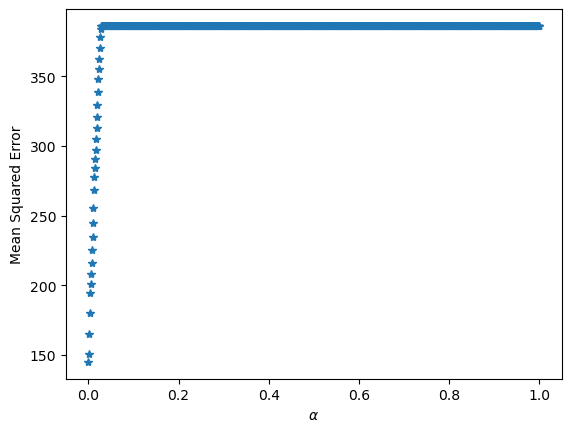

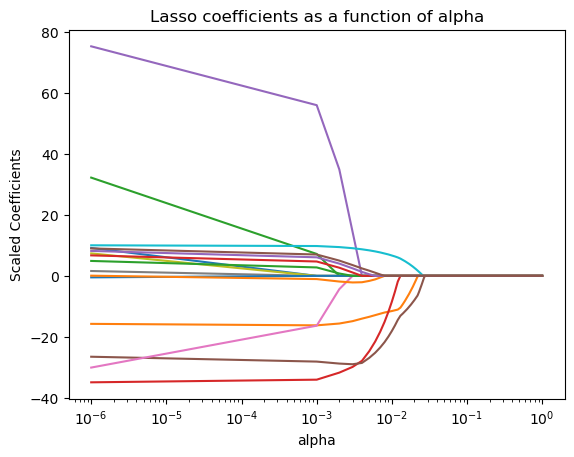

In [190]:
# constructs vector of alpha values
alphas = np.linspace(1e-6, 1, num=1000)

# constructs vectors to store mean prediction errors and coefficients
cv_errs = []
lasso_coefs = []
MSE = 500
bestalpha = 0

# loops for running ridge regression for different values of alpha
for a in alphas:
    lassoReg = make_pipeline(Lasso(alpha=a * np.sqrt(X_train.shape[0])))
    lassoReg.fit(X_train, y_train)
    y_pred = lassoReg.predict(X_test)
    cv_errs.append(mean_squared_error(y_test, y_pred))
    lasso_coefs.append(lassoReg['lasso'].coef_)
    if mean_squared_error(y_test, y_pred) < MSE: 
        MSE = mean_squared_error(y_test, y_pred)
        bestalpha = a

best_lasso_coefs = lasso_coefs[cv_errs.index(min(cv_errs))]
    
print("Best Alpha: ", bestalpha)
print("MSE: ", MSE)

# plots the MSE against the values of alphas
plt.plot(alphas, cv_errs, '*')
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.show()

ax = plt.gca()
ax.plot(alphas, lasso_coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Scaled Coefficients')
plt.title('Lasso coefficients as a function of alpha');


Run a Ridge Regression on the training data and search over different alpha parameters.

Best Alpha:  1e-06
MSE:  145.10117276570847


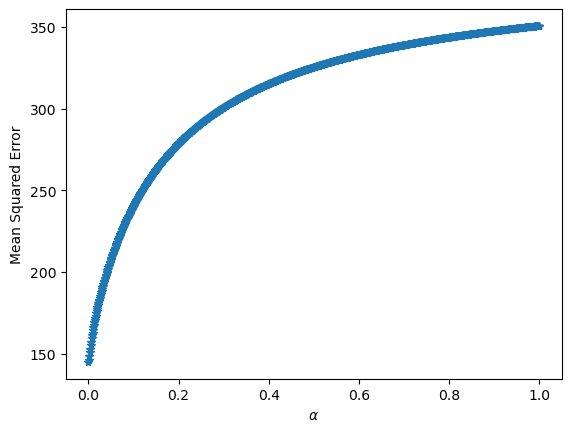

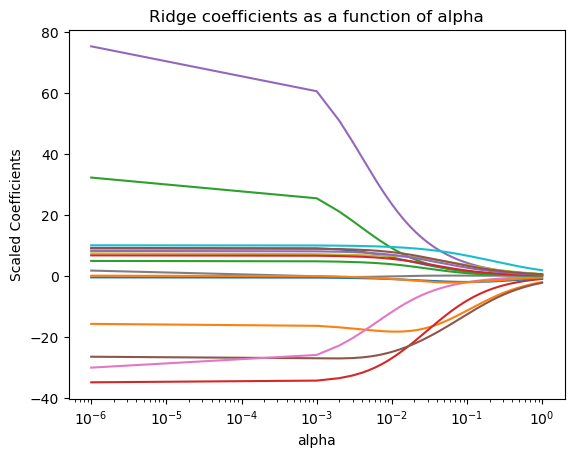

In [191]:
# constructs vector of alpha values
alphas = np.linspace(1e-6, 1, num=1000)

# constructs vectors to store mean prediction errors and coefficients
cv_errs = []
ridge_coefs = []
MSE = 500
bestalpha = 0

# loops for running ridge regression for different values of alpha
for a in alphas:
    ridgeReg = make_pipeline(Ridge(alpha=a * X_train.shape[0]))
    ridgeReg.fit(X_train, y_train)
    y_pred = ridgeReg.predict(X_test)
    cv_errs.append(mean_squared_error(y_test, y_pred))
    ridge_coefs.append(ridgeReg['ridge'].coef_)
    if mean_squared_error(y_test, y_pred) < MSE: 
        MSE = mean_squared_error(y_test, y_pred)
        bestalpha = a
    
best_ridge_coefs = ridge_coefs[cv_errs.index(min(cv_errs))]

print("Best Alpha: ", bestalpha)
print("MSE: ", MSE)

# plots the MSE against the values of alphas
plt.plot(alphas, cv_errs, '*')
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.show()

# plots the coefficients over alpha values
ax = plt.gca()
ax.plot(alphas, np.squeeze(ridge_coefs))
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Scaled Coefficients')
plt.title('Ridge coefficients as a function of alpha');

Compare the regression coefficients from the three different approaches.

In [192]:
# coef_comp = pd.DataFrame({'var': X.columns.tolist(), 
#                           'val_ols': olsReg.params.tolist(),
#                           'val_lasso': best_lasso_coefs,
#                           'val_ridge': best_ridge_coefs[0]})
# print(coef_comp)

# creates new data frame with coefficients
coef_comp = pd.DataFrame({
    'Variable': X.columns.tolist(),
    'Without Charter Dummy': olsReg.params.round(3),
})

# sets index to variable name
coef_comp.set_index('Variable', inplace=True)

# formats the table for Latex
print(coef_comp.style.format("{:.3f}").to_latex())

\begin{tabular}{lr}
 & Without Charter Dummy \\
Variable &  \\
Total Students All Grades (Excludes AE) & 13.760 \\
Free and Reduced Lunch Students Percentage & -14.282 \\
Female Students Percentage & 79.096 \\
American Indian/Alaska Native Students Percentage & -30.840 \\
Asian or Asian/Pacific Islander Students Percentage & 79.043 \\
Hispanic Students Percentage & -22.478 \\
Black or African American Students Percentage & -28.919 \\
Nat. Hawaiian or Other Pacific Isl. Students Percentage & 10.821 \\
Two or More Races Students Percentage & 16.963 \\
School Level: Primary & 11.349 \\
School Level: Middle & 1.017 \\
2015 & 2.636 \\
2016 & 7.197 \\
2017 & 8.756 \\
2018 & 10.085 \\
2019 & 10.758 \\
\end{tabular}



Follows the same steps as in the previous cells but with the input 'Chater School Dummy.' 

In [193]:
# columns to be used for analysis
X = df_combined[['Charter School Dummy', 'Total Students All Grades (Excludes AE)', 'Free and Reduced Lunch Students Percentage', 
                'Female Students Percentage', 'American Indian/Alaska Native Students Percentage', 
                'Asian or Asian/Pacific Islander Students Percentage', 'Hispanic Students Percentage', 
                'Black or African American Students Percentage', 
                'Nat. Hawaiian or Other Pacific Isl. Students Percentage', 'Two or More Races Students Percentage',
                'School Level: Primary', 'School Level: Middle', '2015', '2016', '2017', '2018', '2019']]
y = df_combined[['Average Percent Passing']]

# normalizes the predictor variables
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# splits the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.20)

# performs OLS regression and summarizes regression
olsReg = sm.OLS(y_train,X_train).fit()
print(olsReg.summary())

# uses regression to predict with test data
y_pred = olsReg.predict(X_test)

# compares the predicted values to the actual values to evaluate model performance
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('R-squared:', r2)
print('Mean squared error:', mse)

                                   OLS Regression Results                                   
Dep. Variable:     Average Percent Passing   R-squared (uncentered):                   0.913
Model:                                 OLS   Adj. R-squared (uncentered):              0.913
Method:                      Least Squares   F-statistic:                              5075.
Date:                     Fri, 24 Mar 2023   Prob (F-statistic):                        0.00
Time:                             11:44:56   Log-Likelihood:                         -32613.
No. Observations:                     8269   AIC:                                  6.526e+04
Df Residuals:                         8252   BIC:                                  6.538e+04
Df Model:                               17                                                  
Covariance Type:                 nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025    

Best Alpha:  1e-06
MSE:  141.2054838700103


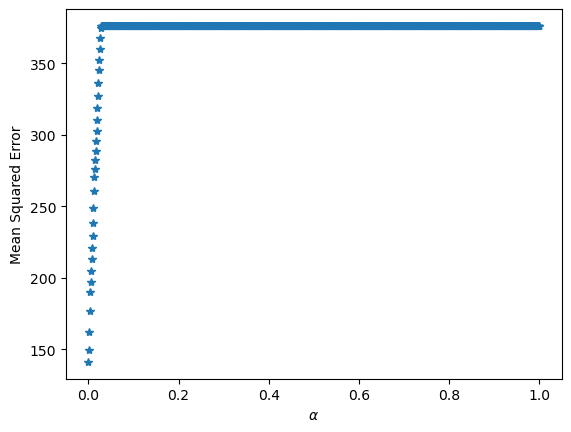

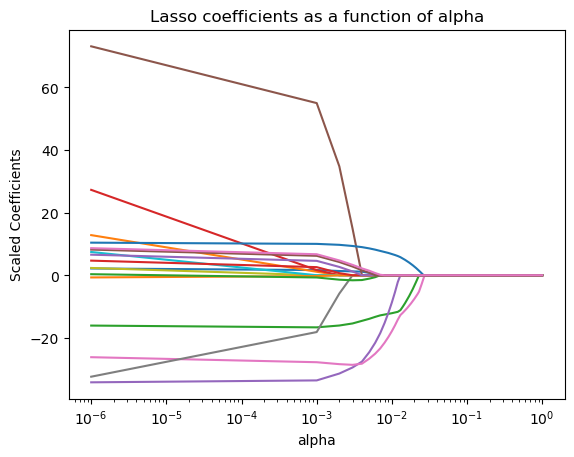

In [194]:
# constructs vector of alpha values
alphas = np.linspace(1e-6, 1, num=1000)

# constructs vectors to store mean prediction errors and coefficients
cv_errs = []
lasso_coefs = []
MSE = 500
bestalpha = 0

# loops for running ridge regression for different values of alpha
for a in alphas:
    lassoReg = make_pipeline(Lasso(alpha=a * np.sqrt(X_train.shape[0])))
    lassoReg.fit(X_train, y_train)
    y_pred = lassoReg.predict(X_test)
    cv_errs.append(mean_squared_error(y_test, y_pred))
    lasso_coefs.append(lassoReg['lasso'].coef_)
    if mean_squared_error(y_test, y_pred) < MSE: 
        MSE = mean_squared_error(y_test, y_pred)
        bestalpha = a
    
best_lasso_coefs = lasso_coefs[cv_errs.index(min(cv_errs))]

print("Best Alpha: ", bestalpha)
print("MSE: ", MSE)

# plots the MSE against the values of alphas
plt.plot(alphas, cv_errs, '*')
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.show()

ax = plt.gca()
ax.plot(alphas, lasso_coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Scaled Coefficients')
plt.title('Lasso coefficients as a function of alpha');


Best Alpha:  1e-06
MSE:  141.20583964773982


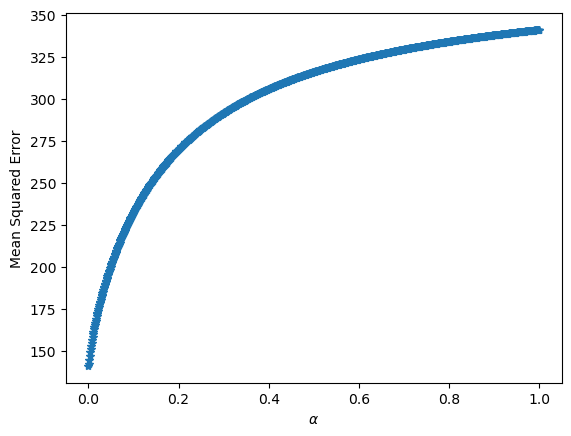

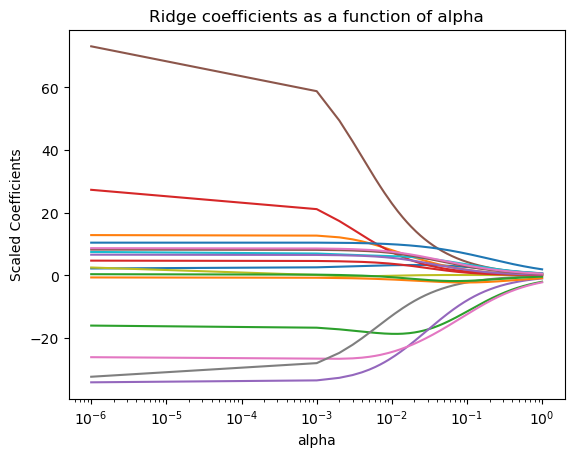

In [195]:
# constructs vector of alpha values
alphas = np.linspace(1e-6, 1, num=1000)

# constructs vectors to store mean prediction errors and coefficients
cv_errs = []
ridge_coefs = []
MSE = 500
bestalpha = 0

# loops for running ridge regression for different values of alpha
for a in alphas:
    ridgeReg = make_pipeline(Ridge(alpha=a * X_train.shape[0]))
    ridgeReg.fit(X_train, y_train)
    y_pred = ridgeReg.predict(X_test)
    cv_errs.append(mean_squared_error(y_test, y_pred))
    ridge_coefs.append(ridgeReg['ridge'].coef_)
    if mean_squared_error(y_test, y_pred) < MSE: 
        MSE = mean_squared_error(y_test, y_pred)
        bestalpha = a

best_ridge_coefs = ridge_coefs[cv_errs.index(min(cv_errs))]

print("Best Alpha: ", bestalpha)
print("MSE: ", MSE)

# plots the MSE against the values of alphas
plt.plot(alphas, cv_errs, '*')
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.show()

# plots the coefficients over alpha values
ax = plt.gca()
ax.plot(alphas, np.squeeze(ridge_coefs))
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Scaled Coefficients')
plt.title('Ridge coefficients as a function of alpha');

In [197]:
# coef_comp = pd.DataFrame({'var': X.columns.tolist(), 
#                           'val_ols': olsReg.params.tolist(),
#                           'val_lasso': best_lasso_coefs,
#                           'val_ridge': best_ridge_coefs[0]})
# print(coef_comp)

# creates new data frame with coefficients
coef_comp = pd.DataFrame({
    'Variable': X.columns.tolist(),
    'With Charter Dummy': olsReg.params.round(3),
})

# sets index to variable name
coef_comp.set_index('Variable', inplace=True)

# formats the table for Latex
print(coef_comp.style.format("{:.3f}").to_latex())

\begin{tabular}{lr}
 & With Charter Dummy \\
Variable &  \\
Charter School Dummy & 2.230 \\
Total Students All Grades (Excludes AE) & 17.428 \\
Free and Reduced Lunch Students Percentage & -14.731 \\
Female Students Percentage & 76.805 \\
American Indian/Alaska Native Students Percentage & -29.888 \\
Asian or Asian/Pacific Islander Students Percentage & 77.396 \\
Hispanic Students Percentage & -21.767 \\
Black or African American Students Percentage & -31.449 \\
Nat. Hawaiian or Other Pacific Isl. Students Percentage & 12.104 \\
Two or More Races Students Percentage & 17.723 \\
School Level: Primary & 11.776 \\
School Level: Middle & 0.942 \\
2015 & 3.025 \\
2016 & 7.094 \\
2017 & 8.749 \\
2018 & 10.101 \\
2019 & 10.489 \\
\end{tabular}

